# Calculate cross-entropy between posts and comments of other subreddits vs. r/science
This is the analysis for results reported in Figure 2

In [1]:
import os

os.chdir('/homes/gws/taugust/Projects/ARK/community_guidelines')

%run Reddit/SRILM_building_funcs.ipynb
subs = ['news', 'politics', 'pics', 'funny', 'AskReddit', 'AskHistorians', 'EverythingScience', 'Futurology', 'science', 'TrueReddit', 'dataisbeautiful', 'askscience']

print("new subs")

/homes/gws/taugust/Projects/ARK/community_guidelines
new subs


# Get top posts for r/science


In [2]:


def print_authorship(df):
    print(len(df), df.author.nunique())
    print(len(df)/df.author.nunique())
    
def get_text(df, num_docs=None, word_count=10):
    if num_docs is not None:
        df = df.sample(num_docs)
    return [word_tokenize(text)[:word_count] for text in df['body']]

def get_top_bottom_middle_posts(df_posts):
    # get top middle and bottom posts
    top = df_posts.score.describe()['75%']
    bottom = df_posts.score.describe()['25%']
        
    df_top_posts = df_posts[df_posts.score >= top].copy()
    df_mid_posts = df_posts[(df_posts['score'] > bottom) & (df_posts['score'] < top)]
    df_bottom_posts = df_posts[df_posts.score <= bottom].copy()
    
    return df_top_posts, df_mid_posts, df_bottom_posts
    
def build_LM(df_posts, year):
    
    df_top_posts, df_mid_posts, df_bottom_posts = get_top_bottom_middle_posts(df_posts)
    
    # top set of posts written by smaller number of people than bottom set of posts
    print('total:', end=' ')
    print_authorship(df_posts) 
    
    print('top:', end=' ')
    print_authorship(df_top_posts) 
    
    print('bottom:', end=' ')
    print_authorship(df_bottom_posts) 
    
    # Build LM
    top_posts_train, top_posts_test = train_test_split(df_top_posts, test_size=0.1, random_state=100)
    top_post_train_text = get_text(top_posts_train)

    # I am not using any of my previous higher-level functions just to get a little more flexibility here
    corpus_path = export_text(top_post_train_text, name=str(uuid.uuid4()), corpus_path='/tmp/')
    count_file = '../srilms_LMs/counts/top_posts_science_'+year+'.count'
    lm_path = '../srilms_LMs/'+ year + '/top_posts_science.lm'
    ngram_count_command='./../../tools/SRILM/bin/i686-m64/ngram-count'
    
    train_SRILM(ngram_count_command, corpus_path, count_file, lm_path)
    
    return lm_path, top_posts_test


def get_entropy(df, lm):
    text = get_text(df)
    text_path = export_text(text, name=str(uuid.uuid4()), corpus_path='/tmp/')
    
    ngram_command = '/homes/gws/taugust/tools/SRILM/bin/i686-m64/ngram'
    
    return get_SRILM_entropy(ngram_command, lm, text_path)


In [4]:
def plot_entropies(df, year, ax=None):
    lm, df_top_posts_test = build_LM(df, year)
    _, df_mid, df_bottom = get_top_bottom_middle_posts(df)
    entropies = [
                    get_entropy(df_top_posts_test, lm),
                    get_entropy(df_mid, lm),
                    get_entropy(df_bottom, lm)
                ]
    
    return sns.barplot(y=entropies, x=['top', 'mid', 'bottom'], ax=ax)
    

In [5]:
# fig

# Doing the same for comments


# Comparing r/science to all other community posts

Language model first -- compare to posts in other 6 communities

In [6]:
# get the language models

post_based_slms = build_total_SLM_SRILM(None, None, slm_count=100, name='science', use_saved_lms=True, kind='post', year='2018', full=False,vocab='data/cleaned/science_post_vocab_15k.txt');
comment_based_slms = build_monthly_SLM_SRILM(None, None, 100, name='science', use_saved_lms=True, kind='comment', year='2018', full=False, vocab='data/cleaned/science_comment_vocab_15k.txt');

# post_based_slms_full = build_total_SLM_SRILM(None, None, slm_count=100, name='science', use_saved_lms=True, kind='post', year='2018', full=True, vocab=None);
# comment_based_slms_full = build_monthly_SLM_SRILM(None, None, 100, name='science', use_saved_lms=True, kind='comment', year='2018', full=True, vocab=None);



In [ ]:
subs = ['news', 'politics', 'pics', 'funny', 'AskReddit', 'AskHistorians', 'EverythingScience', 'Futurology', 'science', 'TrueReddit', 'dataisbeautiful', 'askscience']

df_posts_gap_list = []
df_comments_gap_list = []

rows = []

year = '2018'
for s in subs:
    print(colored(s, 'magenta'))
    df_posts = pd.read_csv('data/cleaned/sub_posts/'+s+'_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\', usecols=['fulltext', 'author', 'subreddit', 'created_month'])
    df_posts = df_posts.rename(index=str, columns={'fulltext': 'body'})
    df_comments = pd.read_csv('data/cleaned/sub_comments/'+s+'_comments_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\', usecols=['body', 'author', 'subreddit', 'created_month'])
    df_author_counts_test = pd.read_csv('data/cleaned/sub_author_counts/'+s+'_author_counts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
    
    for i in range(12):

        _, (active_ent_post, _) = calc_single_acc_gap_SRILM(post_based_slms, df_author_counts_test, df_posts, s, kind='post', month=None, 
                                                num_active_authors=10, num_active_posts=5, num_outside_authors=50, num_outside_posts=1)
        
        rows.extend([{'sub':s, 'year':year, 'type':'post', 'entropy':ent} for ent in active_ent_post])

    _, entropies_comments = calc_acc_gap_SRILM(comment_based_slms, df_author_counts_test, df_comments, s, kind='comment',
                                       num_active_authors=10, num_active_posts=5, num_outside_authors=50, num_outside_posts=1)
    
    rows.extend([{'sub':s, 'year':year, 'type':'comment', 'entropy':ent} for ent in list(flatten(entropies_comments['inside']))])

df_rows = pd.DataFrame(rows)


news
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
No month...taking all author counts
sampled active users: 10 sampled outside users: 50
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [3]:
def get_mean(row):
    try:
        return np.mean(row)
    except:
        return row

In [4]:
# df_rows.to_csv('data/cleaned/all_entropies_subs_new_LMs_15k:science_vocab_based.csv')

df_rows = pd.read_csv('data/cleaned/all_entropies_subs_new_LMs.csv')

df_post_entropy = df_rows[df_rows['type'] == 'post']
df_com_entropy = df_rows[df_rows['type'] == 'comment']


# df_rows = df_rows.dropna(subset=['type'])
# df_com_entropy['ent'] = [get_mean(x) for x in df_com_entropy['entropy']]
# df_rows['science'] = df_rows['sub'] == 'science'

In [5]:
df_rows['sub'] = df_rows['sub'].str.lower()

In [6]:
df_rows['sub'].value_counts()

news                 2400
politics             2400
askreddit            2400
dataisbeautiful      2400
science              2400
everythingscience    2400
pics                 2400
truereddit           2400
askhistorians        2400
askscience           2400
futurology           2400
funny                2400
Name: sub, dtype: int64

In [ ]:
# get means

In [11]:
df_com_entropy[['sub', 'entropy']].groupby(['sub']).mean()

,entropy
sub,
AskHistorians,7.104362
AskReddit,7.377417
EverythingScience,7.058904
Futurology,7.215391
TrueReddit,7.039014
askscience,7.033849
dataisbeautiful,7.186207
funny,7.229006
news,7.239340


In [10]:
df_post_entropy[['sub', 'entropy']].groupby(['sub']).mean()

,entropy
sub,
AskHistorians,7.963177
AskReddit,8.499118
EverythingScience,8.132490
Futurology,8.223594
TrueReddit,7.967811
askscience,8.400702
dataisbeautiful,7.980553
funny,8.459645
news,8.054149


F (  11 ,  14388 ) = 3995.661  p = 0.0000000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4fe9f2a5c0>,
 <matplotlib.colorbar.ColorbarBase at 0x7f4fe83f8668>)

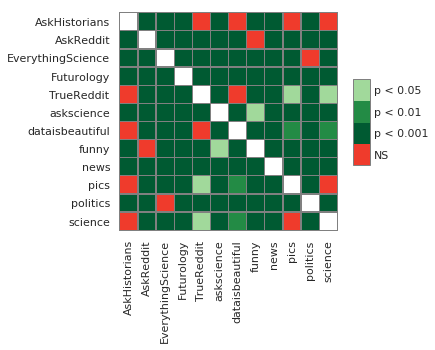

In [17]:
# run tests on CE across posts 
df_post_pivot = df_post_entropy.drop(['type', 'year'], axis=1).pivot(index=None, columns='sub', values='entropy')
run_anova([df_post_pivot[s].dropna().values for s in subs], True)
pc = sp.posthoc_mannwhitney(df_post_entropy, val_col='entropy', group_col='sub', p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

F (  11 ,  14388 ) = 1615.158  p = 0.0000000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4fe8416518>,
 <matplotlib.colorbar.ColorbarBase at 0x7f4fe83eb780>)

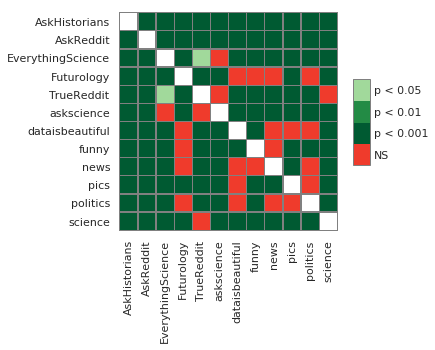

In [18]:
# Run same ones for comments
df_com_pivot = df_com_entropy.drop(['type', 'year'], axis=1).pivot(index=None, columns='sub', values='entropy')
run_anova([df_com_pivot[s].dropna().values for s in subs], True)
pc = sp.posthoc_mannwhitney(df_com_entropy, val_col='entropy', group_col='sub', p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [13]:
# make ordering for graph
post_order = df_rows[df_rows['type'] == 'post'].groupby(['sub'])['entropy'].mean().sort_values().index.to_list()
comment_order = df_rows[df_rows['type'] == 'comment'].groupby(['sub'])['entropy'].mean().sort_values().index.to_list()

Text(0.5, 0.98, 'Cross entropy across subreddits')

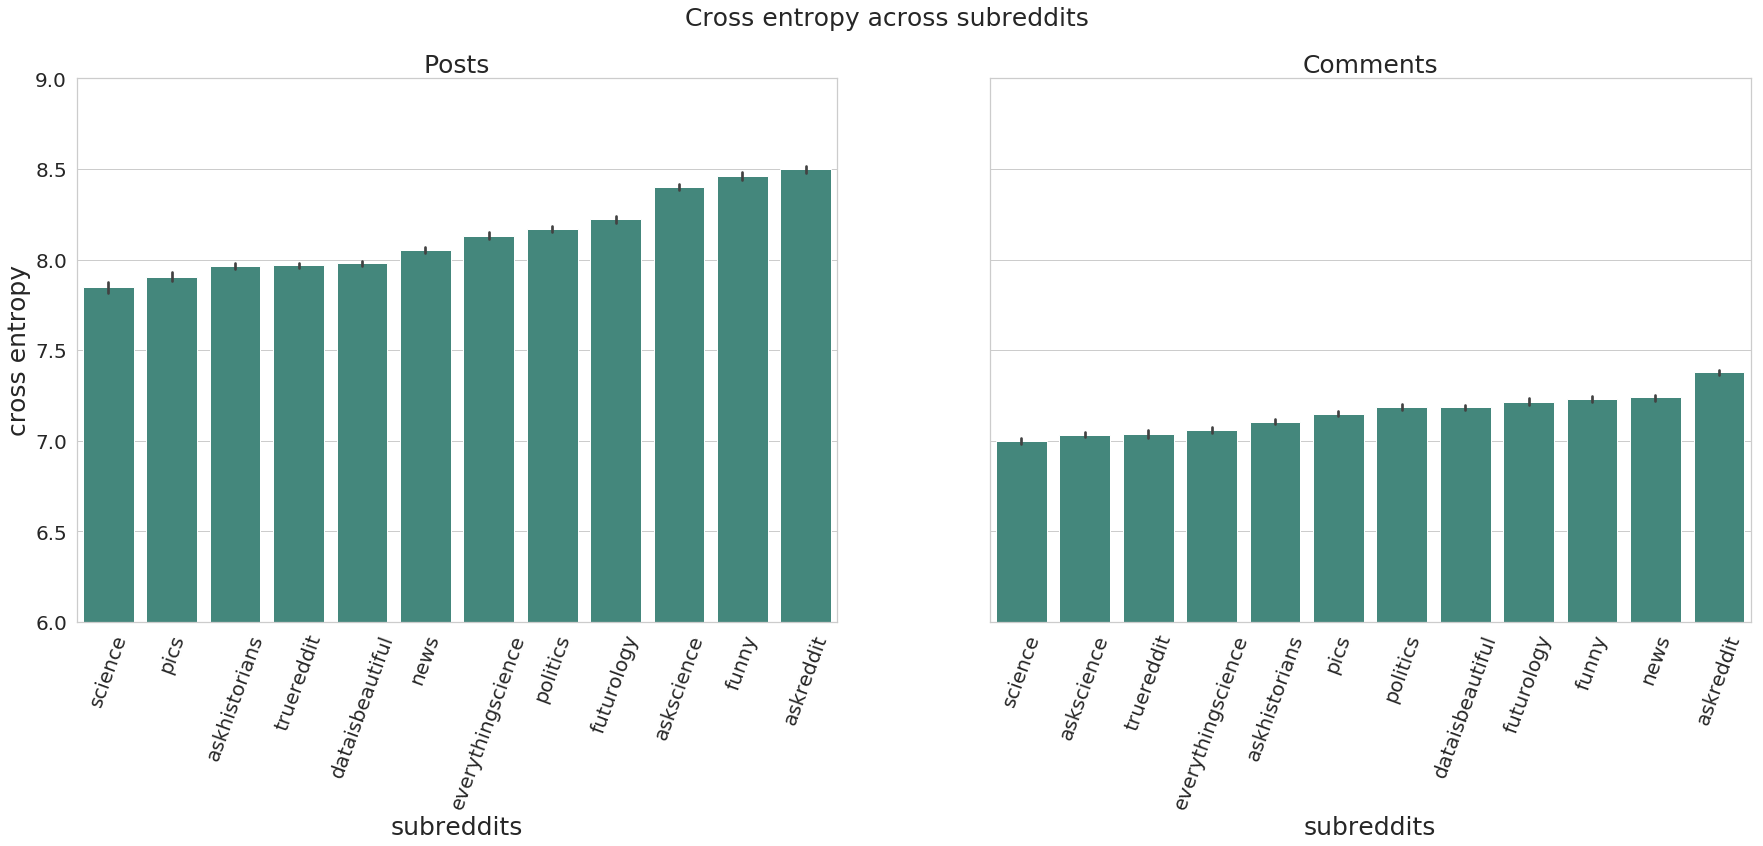

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(30,10))


sns.barplot(x='sub', y='entropy', data=df_rows[df_rows['type'] == 'post'], color='#399283', order=post_order, ax=axs[0])

axs[0].set_title('Posts', fontsize=25)
axs[0].set_ylabel('cross entropy', fontsize=25)
axs[0].set_xlabel('subreddits', fontsize=25)
axs[0].tick_params(axis='x', which='major', labelsize=20, rotation=70)
axs[0].tick_params(axis='y', which='major', labelsize=20)
axs[0].set_ylim(6, 9)

sns.barplot(x='sub', y='entropy', data=df_rows[df_rows['type'] == 'comment'], color='#399283',order=comment_order, ax=axs[1])

axs[1].set_title('Comments', fontsize=25)
axs[1].set_ylabel('', fontsize=25)
axs[1].set_xlabel('subreddits', fontsize=25)
axs[1].tick_params(axis='x', which='major', labelsize=20, rotation=70)
axs[1].set_ylim(6, 9)

fig.suptitle('Cross entropy across subreddits', fontsize=25)


In [19]:
# some post hoc analysis of why pics and science are so close 
def print_sample(df, sample, col):
    df.sample(sample)[col].apply(lambda x: print(colored('---------', 'red'), x))
    
df_posts_pics = pd.read_csv('data/cleaned/sub_posts/pics_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\', usecols=['title', 'fulltext', 'selftext'])
df_posts_science = pd.read_csv('data/cleaned/sub_posts/science_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\', usecols=['title', 'fulltext', 'selftext'])
df_posts_askreddit = pd.read_csv('data/cleaned/sub_posts/AskReddit_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\', usecols=['title', 'fulltext', 'selftext'])
df_posts_askscience = pd.read_csv('data/cleaned/sub_posts/askscience_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\', usecols=['title', 'fulltext', 'selftext'])
df_posts_askhsitorians = pd.read_csv('data/cleaned/sub_posts/AskHistorians_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\', usecols=['title', 'fulltext', 'selftext'])


In [20]:
print_sample(df_posts_askhsitorians, 10, 'title')

--------- A video series by the Youtube Channel "Extra Credits" claims Suleiman the Magnificent only ever referred to Holy Roman Emperor Charles V as "That Spanish Prince" due to the fact both claimed the title of Roman Emperor. Is there any truth to this claim?
--------- Why did Islam not adapt to science like Christianity did Despite Isam having a sort of 'head start'?
--------- How common were public bathhouses and who ran them?
--------- The genocidal Yugoslav Wars &amp; the country's violent breakup are often described as an inevitability held in check by the authoritarian President for Life Tito. But a decade passed between his death &amp; the first Yugoslav War. Was secession inevitable? Why did the first war happen in 1991 &amp; not 1980?
--------- "Consolidate" I hear this word so much in terms of history, What does it actually mean?
--------- Were myths all purely fiction or just dramatised?
--------- How did gold become the universal currency for ancient civilizations worldw

In [53]:
print_sample(df_posts_pics, 10, 'title')

--------- A gift by its value and effort the person done to get it to you not by its price
--------- Photo of a boy in Egypt that I took a couple of years back.
--------- Lost our beloved Molle today, Thank you for a wounderful 14 years
--------- Been developing my illustration style over the last couple months and like where it's heading
--------- Shout out to this dope ass rock spoiled by name carvers
--------- The wind use my negligent neighbor to set my yard on fire.
--------- Made from glitter measuring 24in x 20in took 100 hours to finish
--------- Even the fog settling down, but you denied to settle down with me! #damndude #funny #dark #iamthejoke ��
--------- Is there Anyone on Here that Can Figure Out that Plate Number? Know It's Idado Methheads, Speedin' Out of My Drive Way that's All I know didn't get Good Quick Pic.
--------- got the same toaster oven a few years later. (Old vs New)


In [54]:
print_sample(df_posts_science, 10, 'title')

--------- A majority of countries currently use resources (defined as water, soil nutrients, CO2, etc.) unsustainably. If all people on earth use resources at a rate of those who currently enjoy 'high life satisfaction' (a qualitative index), we would use 2-6X more resources than we do now
--------- Trump’s environmental nominee: Carbon dioxide isn’t pollution because our bodies are made of carbon
--------- Mothers should wait at least a year between giving birth and getting pregnant again to reduce health risks to mother and baby, a new study says.
--------- Is it possible to save multiple Invoices as PDF QuickBooks
--------- The Liking Gap in Conversations: Do People Like Us More Than We Think
--------- Proteins found in the antenna-like projections of neurons, called cilia, are linked with obesity, according to three reports in Nature Genetics--two studies in humans and one in mice.
--------- Activated skin stem cells smoothen out differences in their neighbours
--------- Naturally 

In [55]:
print_sample(df_posts_askreddit, 10, 'title')

--------- Be completely honest, how differently did you find yourself treating your friend after she/he got cosmetic surgery (nose job, boob job, etc)?
--------- What’s a tradition you or your family used to do that you miss?
--------- What did you think you'd never have the strength to survive but did?
--------- Men of reddit who have lost their hair, what advice do you have for a guy that is starting to go bald?
--------- What is the most odd or most strange song that you unironically enjoy?
--------- How many years did he spend reliving the same day in the movie Groundhog’s day to accomplish everything he did?
--------- If you could teach the entire world one concept, what would it be?
--------- What would you do if you were immortal, but your physical body was gone and your brain was preserved in a jar (think Futurama)?
--------- Redditors who have never had a pet animal in their home since birth, what will be your first pet?
--------- When do you sing "Happy Birthday" to someone? 

No handles with labels found to put in legend.


(6, 9)

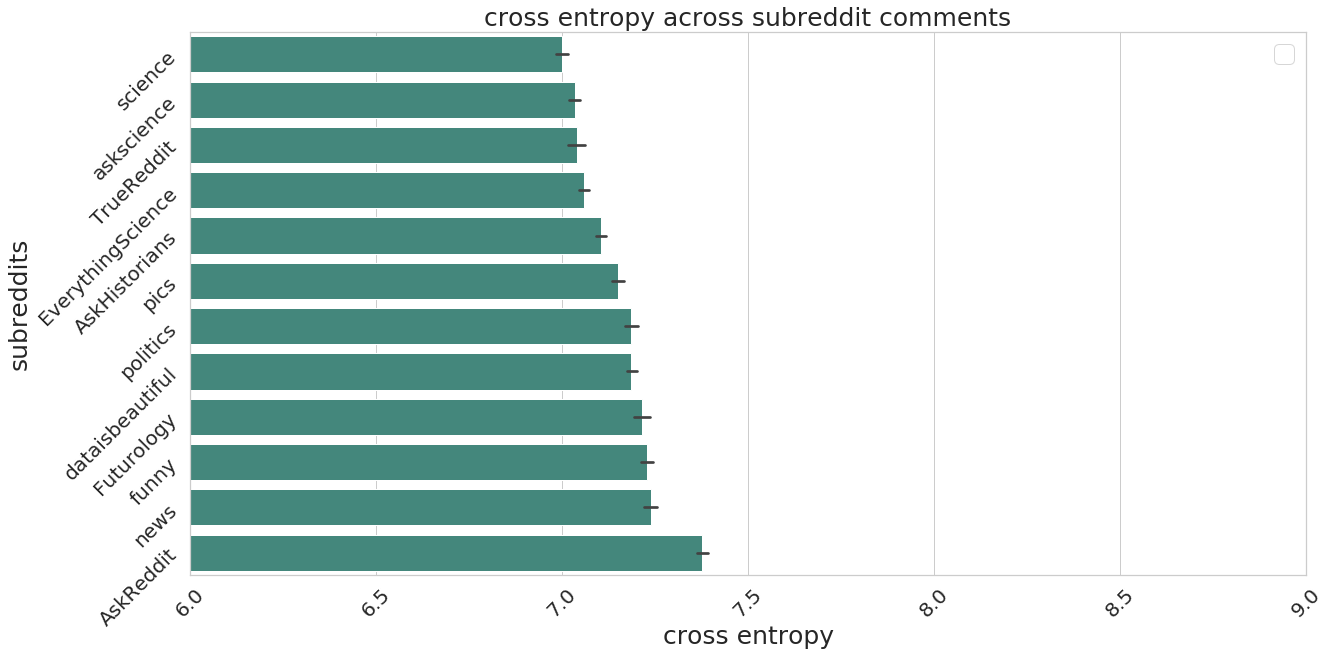

In [18]:
sns.set(style="whitegrid")

plt.figure(figsize=(20,10))
ax = sns.barplot(y='sub', x='entropy', data=df_rows[df_rows['type'] == 'comment'], color='#399283', order=comment_order)

ax.set_title('cross entropy across subreddit comments', fontsize=25)
ax.set_xlabel('cross entropy', fontsize=25)
ax.set_ylabel('subreddits', fontsize=25)
ax.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=45)
ax.set_xlim(6, 9)


In [12]:
df_posts = df_rows[df_rows['type'] == 'post']
df_comments = df_rows[df_rows['type'] == 'comment']

sub_posts = []
sub_comments = []
for s in subs:
    sub_posts.append(df_posts[df_posts['sub'] == s]['entropy'])
    sub_comments.append(df_comments[df_comments['sub'] == s]['entropy'])

In [13]:
stats.levene(*sub_comments)

LeveneResult(statistic=9.087837324022836, pvalue=6.230841989457247e-10)

In [21]:
science_sub = df_rows[df_rows['sub'] == 'science']

science_sub_posts = science_sub[science_sub['type'] == 'post']['entropy']
science_sub_comments = science_sub[science_sub['type'] == 'comment']['entropy']

for s, sub_group in df_rows.groupby('sub'):
    print('------------------------------')
    print(s)
    print('------------------------------')
    print('posts', stats.levene(sub_group[sub_group['type'] == 'post']['entropy'], science_sub_posts))
    print('comments', stats.levene(sub_group[sub_group['type'] == 'comment']['entropy'], science_sub_comments))


------------------------------
AskHistorians
------------------------------
posts LeveneResult(statistic=226.7984199063231, pvalue=4.840827864983042e-49)
comments LeveneResult(statistic=6.034482205266921, pvalue=0.014099471263701221)
------------------------------
EverythingScience
------------------------------
posts LeveneResult(statistic=302.75165617159684, pvalue=5.954102065938233e-64)
comments LeveneResult(statistic=5.150543541643737, pvalue=0.02332754481884945)
------------------------------
Futurology
------------------------------
posts LeveneResult(statistic=386.16809986357254, pvalue=7.746940407300045e-80)
comments LeveneResult(statistic=5.048734806786928, pvalue=0.024734539901362866)
------------------------------
TrueReddit
------------------------------
posts LeveneResult(statistic=293.70415364486956, pvalue=3.372614907889967e-62)
comments LeveneResult(statistic=2.087968751107648, pvalue=0.14859400845145976)
------------------------------
askscience
-----------------------